In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from IPython.display import Image

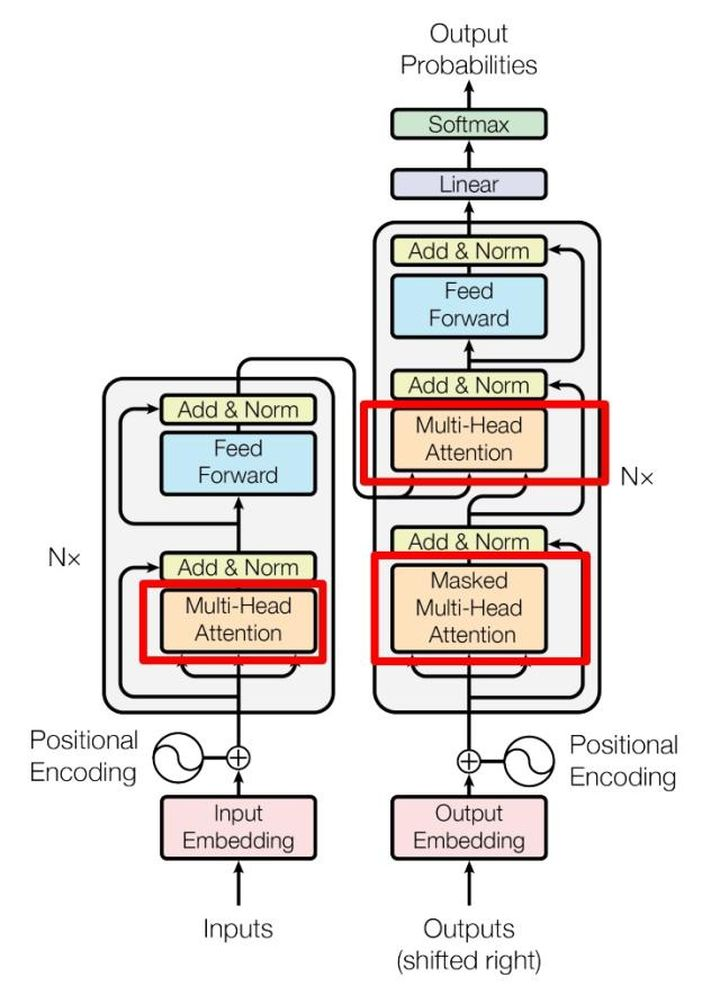

In [2]:
Image('figure/transformer.jpg',width=400,height=300)

In [3]:
## Ê®°ÂûãÂèÇÊï∞
d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention


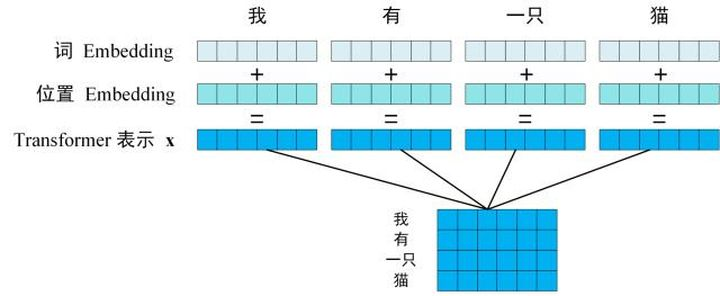

In [5]:
Image('figure/embedding.jpg',width=400,height=300)

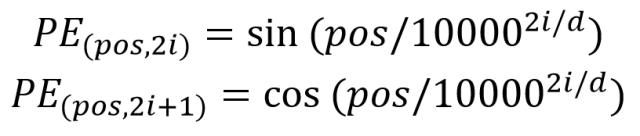

In [6]:
Image('figure/math.png',width=400,height=300)

In [52]:
# ‰ΩçÁΩÆÁºñÁ†ÅÁöÑÂÆûÁé∞ÂÖ∂ÂÆûÂæàÁÆÄÂçïÔºåÁõ¥Êé•ÂØπÁÖßÁùÄÂÖ¨ÂºèÂéªÊï≤‰ª£Á†ÅÂ∞±ÂèØ‰ª•Ôºå‰∏ãÈù¢Ëøô‰∏™‰ª£Á†ÅÂè™ÊòØÂÖ∂‰∏≠‰∏ÄÁßçÂÆûÁé∞ÊñπÂºèÔºõ
# ‰ªéÁêÜËß£Êù•ËÆ≤ÔºåÈúÄË¶ÅÊ≥®ÊÑèÁöÑÂ∞±ÊòØÂÅ∂Êï∞ÂíåÂ•áÊï∞Âú®ÂÖ¨Âºè‰∏äÊúâ‰∏Ä‰∏™ÂÖ±ÂêåÈÉ®ÂàÜÔºåÊàë‰ª¨‰ΩøÁî®lnÂáΩÊï∞ÊääÊ¨°ÊñπÊãø‰∏ãÊù•ÔºåÊñπ‰æøËÆ°ÁÆóÔºõ
# pos‰ª£Ë°®ÁöÑÊòØÂçïËØçÂú®Âè•Â≠ê‰∏≠ÁöÑÁ¥¢ÂºïÔºåËøôÁÇπÈúÄË¶ÅÊ≥®ÊÑèÔºõÊØîÂ¶Çmax_lenÊòØ128‰∏™ÔºåÈÇ£‰πàÁ¥¢ÂºïÂ∞±ÊòØ‰ªé0Ôºå1Ôºå2Ôºå...,127
# ÂÅáËÆæÊàëÁöÑdemodelÊòØ512Ôºå2iÈÇ£‰∏™Á¨¶Âè∑‰∏≠i‰ªé0ÂèñÂà∞‰∫Ü255ÔºåÈÇ£‰πà2iÂØπÂ∫îÂèñÂÄºÂ∞±ÊòØ0,2,4...510
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        # max_len 5000 ÊòØÂÆö‰πâËæìÂÖ•Ê®°ÂûãÁöÑÊúÄÂ§ßÈïøÂ∫¶
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)  
        # Ëøô‰∏™ÂÖ∂ÂÆûÂ∞±ÊòØÂéªÂÆö‰πâÁîüÊàê‰∏Ä‰∏™Áü©ÈòµËøõË°å ËØçembeddingÔºåÂ§ßÂ∞èÊòØ [src_vocab_size,  d_model]
        
        pos = np.arange(max_len)[:, None]  # [max_len, 1]Êâ©Â±ï‰∏Ä‰∏™Áª¥Â∫¶‰∏∫‰∫ÜÂêéÈù¢Áü©ÈòµËøêÁÆó
        pe = pos / np.power(10000, 2. * np.arange(d_model)[None, :] / d_model)  
        pe[:, 0::2] = np.sin(pe[:, 0::2])
        pe[:, 1::2] = np.cos(pe[:, 1::2])  # pe [max_len, dim]
        pe = torch.tensor(pe, dtype=torch.float)
        pe = pe.unsqueeze(0)   # pe[1, max_len, dim]  # Êï∞ÊçÆËæìÂÖ•Á¨¨‰∏Ä‰∏™Áª¥Â∫¶‰∏∫batch_size
                                
        self.register_buffer('pe', pe)  ## ÂÆö‰∏Ä‰∏™ÁºìÂÜ≤Âå∫ÔºåÂÖ∂ÂÆûÁÆÄÂçïÁêÜËß£‰∏∫Ëøô‰∏™ÂèÇÊï∞‰∏çÊõ¥Êñ∞Â∞±ÂèØ‰ª•
        
    def forward(self, x):
        # x [batch_size, seq_len]
        x = x + self.pe[:, :x.size(1), :]   # word embedding + positional embedding
        
        return x

# Â§öÂ§¥Ê≥®ÊÑèÂäõÊú∫Âà∂

## Â§öÂ§¥Ê≥®ÊÑèÂäõÊú∫Âà∂ÊòØÁî±Â§ö‰∏™Self-AttentionÁªÑÊàêÁöÑ
ÂèØ‰ª•ÁúãÂà∞ Encoder block ÂåÖÂê´‰∏Ä‰∏™ Multi-Head AttentionÔºåËÄå Decoder block ÂåÖÂê´‰∏§‰∏™ Multi-Head Attention (ÂÖ∂‰∏≠Êúâ‰∏Ä‰∏™Áî®Âà∞ Masked)„ÄÇMulti-Head Attention ‰∏äÊñπËøòÂåÖÊã¨‰∏Ä‰∏™ Add & Norm Â±ÇÔºåAdd Ë°®Á§∫ÊÆãÂ∑ÆËøûÊé• (Residual Connection) Áî®‰∫éÈò≤Ê≠¢ÁΩëÁªúÈÄÄÂåñÔºåNorm Ë°®Á§∫ Layer NormalizationÔºåÁî®‰∫éÂØπÊØè‰∏ÄÂ±ÇÁöÑÊøÄÊ¥ªÂÄºËøõË°åÂΩí‰∏ÄÂåñ„ÄÇ

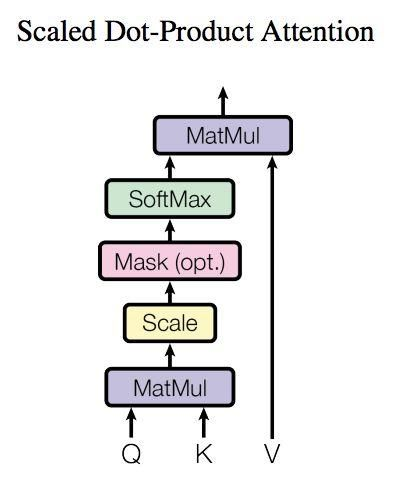

In [8]:
Image('figure/self-attention.jpg',width=400,height=300)

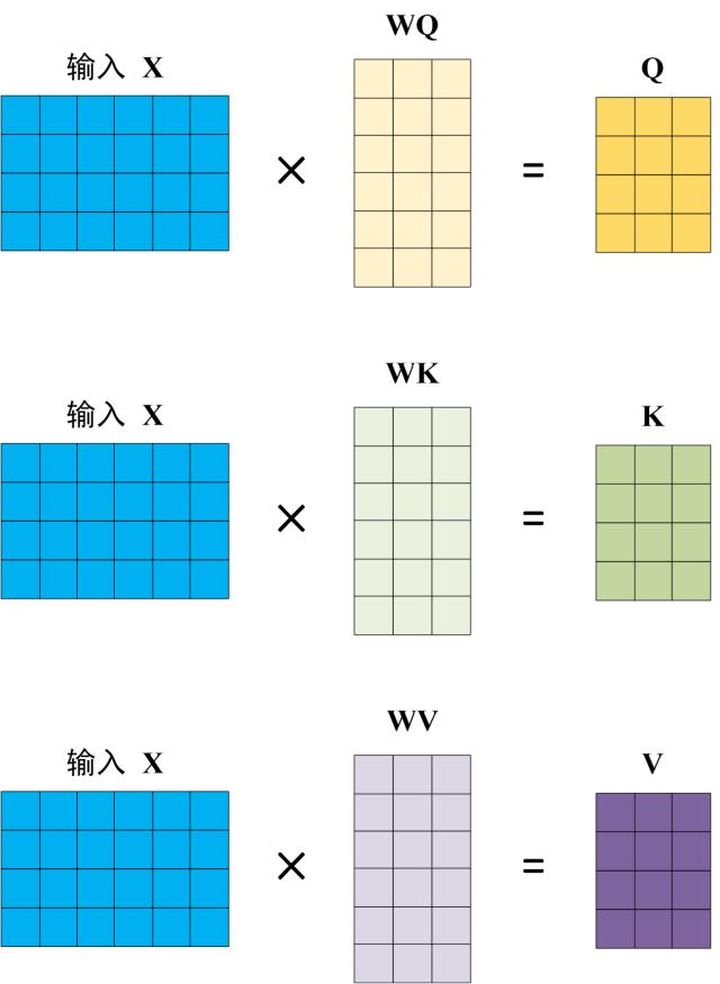

In [9]:
Image('figure/KQV.jpg',width=400,height=300)

### K„ÄÅQ„ÄÅVËÆ°ÁÆóSelf-Attention ÁöÑËæìÂÖ•Áî®Áü©ÈòµX(seq_len, d_model)ËøõË°åË°®Á§∫ÔºåÂàôÂèØ‰ª•‰ΩøÁî®Á∫øÊÄßÂèòÈòµÁü©Èòµ(ÂèØ‰ª•ÈÄöËøáÂÖ®ËøûÊé•Â±ÇËé∑Âæó)WQ,WK,WVËÆ°ÁÆóÂæóÂà∞Q,K,V„ÄÇËÆ°ÁÆóÂ¶Ç‰∏äÂõæÊâÄÁ§∫ÔºåÊ≥®ÊÑè X, Q, K, V ÁöÑÊØè‰∏ÄË°åÈÉΩË°®Á§∫‰∏Ä‰∏™ÂçïËØç

## ÂæóÂà∞Áü©Èòµ Q, K, V‰πãÂêéÂ∞±ÂèØ‰ª•ËÆ°ÁÆóÂá∫ Self-Attention ÁöÑËæìÂá∫‰∫ÜÔºåËÆ°ÁÆóÁöÑÂÖ¨ÂºèÂ¶Ç‰∏ã

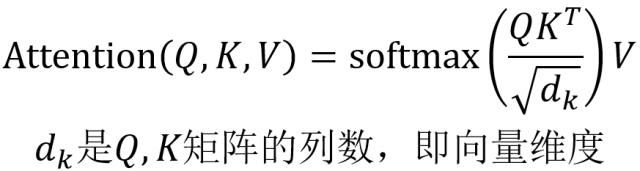

In [10]:
Image('figure/math2.jpg',width=400,height=300)

## ÂÖ¨Âºè‰∏≠ËÆ°ÁÆóÁü©ÈòµQÂíåKÊØè‰∏ÄË°åÂêëÈáèÁöÑÂÜÖÁßØÔºå‰∏∫‰∫ÜÈò≤Ê≠¢ÂÜÖÁßØËøáÂ§ßÔºåÂõ†Ê≠§Èô§‰ª• ùëëùëòÁöÑÂπ≥ÊñπÊ†π„ÄÇQ‰πò‰ª•KÁöÑËΩ¨ÁΩÆÂêéÔºåÂæóÂà∞ÁöÑÁü©ÈòµË°åÂàóÊï∞ÈÉΩ‰∏∫ nÔºån ‰∏∫Âè•Â≠êÂçïËØçÊï∞ÔºåËøô‰∏™Áü©ÈòµÂèØ‰ª•Ë°®Á§∫ÂçïËØç‰πãÈó¥ÁöÑ attention Âº∫Â∫¶„ÄÇ‰∏ãÂõæ1234 Ë°®Á§∫ÁöÑÊòØÂè•Â≠ê‰∏≠ÁöÑÂçïËØç

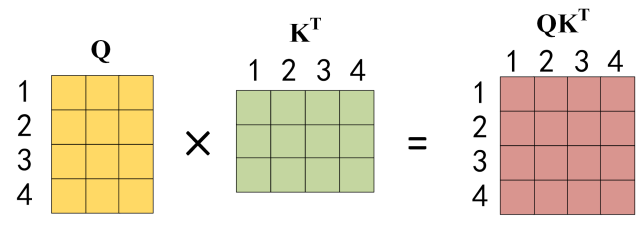

In [11]:
Image('figure/QK.png',width=400,height=300)

ÂæóÂà∞$QK^{T}$ ‰πãÂêéÔºå‰ΩøÁî® Softmax ËÆ°ÁÆóÊØè‰∏Ä‰∏™ÂçïËØçÂØπ‰∫éÂÖ∂‰ªñÂçïËØçÁöÑ attention Á≥ªÊï∞ÔºåÂÖ¨Âºè‰∏≠ÁöÑ Softmax ÊòØÂØπÁü©ÈòµÁöÑÊØè‰∏ÄË°åËøõË°å SoftmaxÔºåÂç≥ÊØè‰∏ÄË°åÁöÑÂíåÈÉΩÂèò‰∏∫ 1

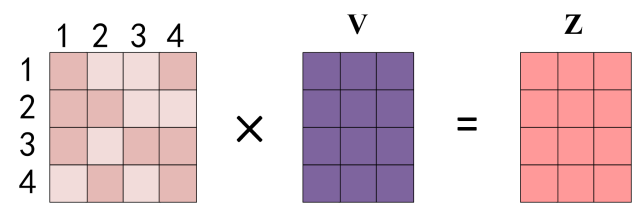

In [12]:
Image('figure/1.png',width=400,height=300)

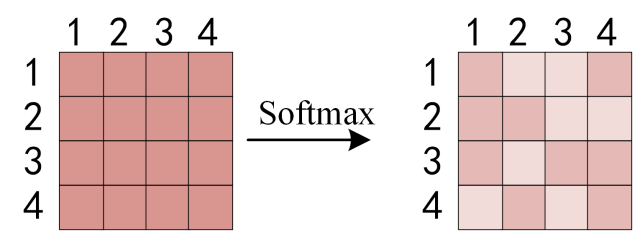

In [13]:
Image('figure/2.png',width=400,height=300)

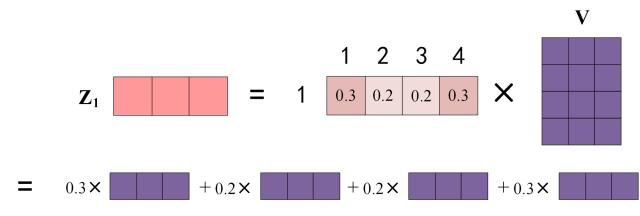

In [14]:
Image('figure/3.jpg',width=400,height=300)

## Âú®‰∏ä‰∏ÄÊ≠•ÔºåÊàë‰ª¨Â∑≤ÁªèÁü•ÈÅìÊÄé‰πàÈÄöËøá Self-Attention ËÆ°ÁÆóÂæóÂà∞ËæìÂá∫Áü©Èòµ ZÔºåËÄå Multi-Head Attention ÊòØÁî±Â§ö‰∏™ Self-Attention ÁªÑÂêàÂΩ¢ÊàêÁöÑÔºå‰∏ãÂõæÊòØËÆ∫Êñá‰∏≠ Multi-Head Attention ÁöÑÁªìÊûÑÂõæ„ÄÇÂØπÂÖ∂ËæìÂÖ•ÁöÑXËøõË°åÂàÜÂ§¥ËÆ°ÁÆó ÂàÜÂ§¥ÈïøÂ∫¶head_dim = d_model / n_heads

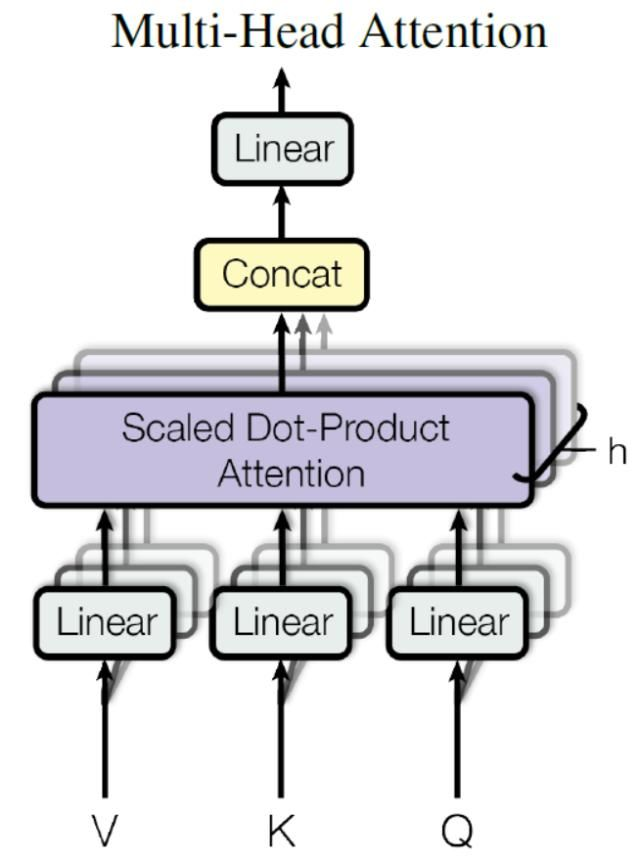

In [15]:
Image('figure/multi-head.jpg',width=400,height=300)

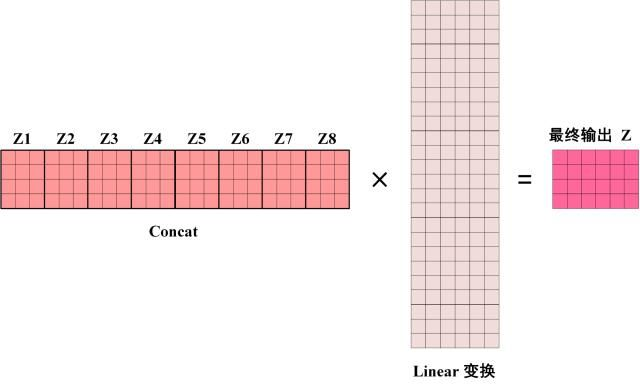

In [16]:
Image('figure/4.jpg',width=400,height=300)

In [53]:
# seq_q Âíå seq_k ‰∏ç‰∏ÄÂÆö‰∏ÄËá¥ÔºåÂú®‰∫§‰∫íÊ≥®ÊÑèÂäõÔºåqÊù•Ëá™Ëß£Á†ÅÁ´ØÔºåk,vÊù•Ëá™ÁºñÁ†ÅÁ´ØÔºåÊâÄ‰ª•ÂëäËØâÊ®°ÂûãÁºñÁ†ÅËøôËæπpadÁ¨¶Âè∑‰ø°ÊÅØÂ∞±ÂèØ‰ª•ÔºåËß£Á†ÅÁ´ØÁöÑpad‰ø°ÊÅØÂú®‰∫§‰∫íÊ≥®ÊÑèÂäõÂ±ÇÊòØÊ≤°ÊúâÁî®Âà∞ÁöÑÔºõ
def get_attn_pad_mask(seq_q, seq_k):
    # ËæìÂÖ• (batch_size, seq_len)
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # paddingÊó∂ 0‰Ωú‰∏∫PaddingÁ¨¶Âè∑ ÁÑ∂ÂêéÂêéÈù¢Ë¢´ËΩ¨Êç¢‰∏∫1
    # eq(zero) is PAD token
    pad_attn_mask = torch.eq(seq_k, 0).float().unsqueeze(1)  # batch_size x 1 x len_k, one is masking eqÂÖÉÁ¥†Á≠â‰∫é0Â°´ÂÖÖtrue Âê¶Âàô‰∏∫false
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k expandÂ§çÂà∂Áª¥Â∫¶

In [37]:
def get_attn_subsequent_mask(seq):
    """
    seq: [batch_size, tgt_len]
    """
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    # attn_shape: [batch_size, tgt_len, tgt_len]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # ÁîüÊàê‰∏Ä‰∏™‰∏ä‰∏âËßíÁü©Èòµ
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask  # [batch_size, tgt_len, tgt_len]

In [38]:
# Âú®‰∫§‰∫íÊ≥®ÊÑèÂäõÂ±ÇK, VÊù•Ëá™ÁºñÁ†ÅÁ´ØËÄåQÊù•Ëá™Ëß£Á†ÅÁ´Ø
class MultiHeadAttention(nn.Module):
    def __init__(self):       
        super().__init__()
        self.head_dim = d_model // n_heads
        # ËæìÂÖ•ËøõÊù•ÁöÑQKVÊòØÁõ∏Á≠âÁöÑÔºå‰ΩøÁî®Êò†Â∞ÑlinearÂÅö‰∏Ä‰∏™Á∫øÊÄßÊò†Â∞ÑÂæóÂà∞ÂèÇÊï∞Áü©ÈòµWq, Wk,Wv
        self.W_Q = nn.Linear(d_model, self.head_dim * n_heads)
        self.W_K = nn.Linear(d_model, self.head_dim * n_heads)
        self.W_V = nn.Linear(d_model, self.head_dim * n_heads)
        self.linear = nn.Linear(self.head_dim * n_heads, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        
    def forward(self, Q, K, V, attn_mask):
        # Ëøô‰∏™Â§öÂ§¥ÂàÜ‰∏∫ËøôÂá†‰∏™Ê≠•È™§ÔºåÈ¶ñÂÖàÊò†Â∞ÑÂàÜÂ§¥ÔºåÁÑ∂ÂêéËÆ°ÁÆóatten_scoresÔºåÁÑ∂ÂêéËÆ°ÁÆóatten_value;
        # ËæìÂÖ•ËøõÊù•ÁöÑÊï∞ÊçÆÂΩ¢Áä∂Ôºö Q: [batch_size x len_q x d_model], K: [batch_size x len_k x d_model], V: [batch_size x len_k x d_model]
        batch_size = Q.size(0)
        # Á¨¨‰∏ÄÊ≠•ÂÖàÊò†Â∞Ñ[batch_size, seq_len, n_heads*head_dim]
        # Á¨¨‰∫åÊ≠•ÂàÜÂ§¥[batch_size, n_heads, seq_len, head_dim]Â∞Ün_headsÂíåseq_len‰∫§Êç¢‰ΩçÁΩÆÊñπ‰æøËøêÁÆó
        Q = self.W_Q(Q).view(batch_size, -1, n_heads, self.head_dim).transpose(1,2)
        K = self.W_K(K).view(batch_size, -1, n_heads, self.head_dim).transpose(1,2)     
        V = self.W_V(V).view(batch_size, -1, n_heads, self.head_dim).transpose(1,2)
        
        # ËæìÂÖ•ËøõË°åÁöÑattn_maskÂΩ¢Áä∂ÊòØ batch_size x len_q x len_kÔºåÁÑ∂ÂêéÁªèËøá‰∏ãÈù¢Ëøô‰∏™‰ª£Á†ÅÂæóÂà∞Êñ∞ÁöÑattn_mask : [batch_size x n_heads x len_q x len_k]ÔºåÂ∞±ÊòØÊääpad‰ø°ÊÅØÈáçÂ§ç‰∫Ün‰∏™Â§¥‰∏ä
        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)

        # ÁÑ∂ÂêéÊàë‰ª¨ËÆ°ÁÆó ScaledDotProductAttention attnÊòØÊ≥®ÊÑèÂäõÁü©ÈòµÁî®‰∫éÂèØËßÜÂåñ
        context, attn = self.scaled_dot_product_attention(Q, K, V, attn_mask) # contex [batch_size, n_heads, len_q, d_model]
        # pytorch ‰∏≠‰∏çÁî®contiguous()‰øÆÊîπÂêéÈù¢ÁöÑÂÄº‰ºöÂØºËá¥ÂâçÈù¢ÁöÑÂÄºÂèëÁîüÊîπÂèò
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * self.head_dim) # context: [batch_size, len_q, n_heads * head_dim]
        output = self.linear(context)
        
        return output, attn
    
    def scaled_dot_product_attention(self, Q, K, V, attn_mask):
        # ËæìÂÖ•ËøõÊù•ÁöÑÁª¥Â∫¶ÂàÜÂà´ÊòØ [batch_size, n_heads,  seq_len,  head_dim] 
        # È¶ñÂÖàÁªèËøámatmulÂáΩÊï∞ÂæóÂà∞ÁöÑscoresÂΩ¢Áä∂ÊòØ : [batch_size,  n_heads,  len_q, len_k]
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.head_dim)

        # ÁÑ∂ÂêéÂÖ≥ÈîÆËØçÂú∞ÊñπÊù•‰∫ÜÔºå‰∏ãÈù¢Ëøô‰∏™Â∞±ÊòØÁî®Âà∞‰∫ÜÊàë‰ª¨‰πãÂâçÈáçÁÇπËÆ≤ÁöÑattn_maskÔºåÊääË¢´maskÁöÑÂú∞ÊñπÁΩÆ‰∏∫Êó†ÈôêÂ∞èÔºåsoftmax‰πãÂêéÂü∫Êú¨Â∞±ÊòØ0ÔºåÂØπqÁöÑÂçïËØç‰∏çËµ∑‰ΩúÁî®
        # Â∞ÜMaskÁöÑpad 1Âèò‰∏∫Êó†Á©∑Â∞èÁöÑÊï∞ÁªèËøásoftmaxÂèò‰∏∫0
        scores.masked_fill_(attn_mask.bool(),-np.inf) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)  # ÂΩìdim=1Êó∂Ôºå ÊòØÂØπÊüê‰∏ÄÁª¥Â∫¶ÁöÑÂàóËøõË°åsoftmaxËøêÁÆó
        context = torch.matmul(attn, V)   # [batch_size, n_heads, len_q, d_model]
        return context, attn
        

In [39]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual)

In [40]:
# EncoderLayer ÔºöÂåÖÂê´‰∏§‰∏™ÈÉ®ÂàÜÔºåÂ§öÂ§¥Ê≥®ÊÑèÂäõÊú∫Âà∂ÂíåÂâçÈ¶àÁ•ûÁªèÁΩëÁªú
class EncoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()
        
    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x seq_len x d_model]
        return enc_outputs, attn
        

In [73]:
# Encoder ÈÉ®ÂàÜÂåÖÂê´‰∏â‰∏™ÈÉ®ÂàÜÔºöËØçÂêëÈáèembeddingÔºå‰ΩçÁΩÆÁºñÁ†ÅÈÉ®ÂàÜÔºåÊ≥®ÊÑèÂäõÂ±ÇÂèäÂêéÁª≠ÁöÑÂâçÈ¶àÁ•ûÁªèÁΩëÁªú
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # ËØçÂêëÈáèembedding
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        # ‰ΩçÁΩÆÁºñÁ†ÅÊÉÖÂÜµÔºåËøôÈáåÊòØÂõ∫ÂÆöÁöÑÊ≠£‰ΩôÂº¶ÂáΩÊï∞Ôºå‰πüÂèØ‰ª•‰ΩøÁî®Á±ª‰ººËØçÂêëÈáèÁöÑnn.EmbeddingËé∑Âæó‰∏Ä‰∏™ÂèØ‰ª•Êõ¥Êñ∞Â≠¶‰π†ÁöÑ‰ΩçÁΩÆÁºñÁ†Å
        self.pos_emb = PositionalEncoding(d_model)  
        # ‰ΩøÁî®ModuleListÂØπÂ§ö‰∏™encoderËøõË°åÂ†ÜÂè†ÔºåÂõ†‰∏∫ÂêéÁª≠ÁöÑencoderÂπ∂Ê≤°Êúâ‰ΩøÁî®ËØçÂêëÈáèÂíå‰ΩçÁΩÆÁºñÁ†ÅÔºåÊâÄ‰ª•ÊäΩÁ¶ªÂá∫Êù•
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)]) 
        
    def forward(self, enc_inputs):
        # ‰ΩçÁΩÆÁºñÁ†Å enc_inputs[batch_size, seq_len]
        x = self.src_emb(enc_inputs)  # x[batch_size, seq_len, d_model]
        x = self.pos_emb(x)   # x[batch_size, seq_len, d_model]
        
        # mask padding 
        # get_attn_pad_maskÊòØ‰∏∫‰∫ÜÂæóÂà∞Âè•Â≠ê‰∏≠padÁöÑ‰ΩçÁΩÆ‰ø°ÊÅØÔºåÁªôÂà∞Ê®°ÂûãÂêéÈù¢ÔºåÂú®ËÆ°ÁÆóËá™Ê≥®ÊÑèÂäõÂíå‰∫§‰∫íÊ≥®ÊÑèÂäõÁöÑÊó∂ÂÄôÂéªÊéâpaddingÁ¨¶Âè∑ÁöÑÂΩ±Âìç
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)
        
        enc_self_attns = []          # ÂÇ®Â≠òÊ≥®ÊÑèÂäõ‰∏∫ÂèØËßÜÂåñÂÅöÂáÜÂ§á
        for layer in self.layers:
            # ÂéªÁúãEncoderLayer Â±ÇÂáΩÊï∞ 
            enc_outputs, enc_self_attn = layer(x, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn.detach().numpy())
        return enc_outputs, enc_self_attns

In [74]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        # ËÆ°ÁÆódecÁöÑËá™Ê≥®ÊÑèÂäõ
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        # ËÆ°ÁÆó‰∫§‰∫íÊ≥®ÊÑèÂäõ
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        # ÂâçÂèçÈ¶àÁ•ûÁªèÁΩëÁªú
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

In [75]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        # ‰ΩçÁΩÆÁºñÁ†Å
        x = self.tgt_emb(dec_inputs)  # [batch_size, tgt_len, d_model]
        x = self.pos_emb(x)
        
        # get_attn_pad_mask Ëá™Ê≥®ÊÑèÂäõÂ±ÇÁöÑÊó∂ÂÄôÁöÑpad ÈÉ®ÂàÜ
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)
        
        # get_attn_subsequent_mask Ëøô‰∏™ÂÅöÁöÑÊòØËá™Ê≥®ÊÑèÂ±ÇÁöÑmaskÈÉ®ÂàÜÔºåÂ∞±ÊòØÂΩìÂâçÂçïËØç‰πãÂêéÁúã‰∏çÂà∞Ôºå‰ΩøÁî®‰∏Ä‰∏™‰∏ä‰∏âËßí‰∏∫1ÁöÑÁü©Èòµ
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)
        
        # decËá™Ê≥®ÊÑèÂäõÂ±ÇÊÄªÁöÑmask ‰∏§‰∏™Áü©ÈòµÁõ∏Âä†ÔºåÂ§ß‰∫é0ÁöÑ‰∏∫1Ôºå‰∏çÂ§ß‰∫é0ÁöÑ‰∏∫0Ôºå‰∏∫1ÁöÑÂú®‰πãÂêéÂ∞±‰ºöË¢´fillÂà∞Êó†ÈôêÂ∞è
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)
        
        # Ëøô‰∏™ÂÅöÁöÑÊòØ‰∫§‰∫íÊ≥®ÊÑèÂäõÊú∫Âà∂‰∏≠ÁöÑmaskÁü©ÈòµÔºåÊâæÂá∫enc ÂíådecÈáåÈù¢ÁöÑpadding
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs)
        
        # ÂÇ®Â≠òdecÁöÑËá™Ê≥®ÊÑèÂäõÂíå‰∫§‰∫íÊ≥®ÊÑèÂäõ ‰∏∫‰∫ÜÂèØËßÜÂåñ
        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(x, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn.detach().numpy())
            dec_enc_attns.append(dec_enc_attn.detach().numpy())
        return dec_outputs, dec_self_attns, dec_enc_attns
    

In [76]:
# ‰ªéÊï¥‰ΩìÁΩëË∑ØÁªìÊûÑÊù•ÁúãÔºåÂàÜ‰∏∫‰∏â‰∏™ÈÉ®ÂàÜÔºöÁºñÁ†ÅÂ±ÇÔºåËß£Á†ÅÂ±ÇÔºåËæìÂá∫Â±Ç
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        # ÁºñÁ†ÅÂ±Ç
        self.encoder = Encoder()
        # Ëß£Á†ÅÂ±Ç
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False) 
        # ËæìÂá∫Â±Ç d_model ÊòØÊàë‰ª¨Ëß£Á†ÅÂ±ÇÊØè‰∏™tokenËæìÂá∫ÁöÑÁª¥Â∫¶Â§ßÂ∞èÔºå‰πãÂêé‰ºöÂÅö‰∏Ä‰∏™ tgt_vocab_size Â§ßÂ∞èÁöÑsoftmax
    
    def forward(self, enc_inputs, dec_inputs):
        """Â¶ÇÂõætransformerÊúâ‰∏§‰∏™ËæìÂÖ•‰∏Ä‰∏™ÊòØenc_inputs ÂΩ¢Áä∂‰∏∫[batch_size, src_len]Ôºå‰∏ªË¶ÅÊòØ‰Ωú‰∏∫ÁºñÁ†ÅÊÆµÁöÑËæìÂÖ•Ôºå
        ‰∏Ä‰∏™dec_inputsÔºåÂΩ¢Áä∂‰∏∫[batch_size, tgt_len]Ôºå‰∏ªË¶ÅÊòØ‰Ωú‰∏∫Ëß£Á†ÅÁ´ØÁöÑËæìÂÖ•"""
        
        # enc_inputs‰Ωú‰∏∫ËæìÂÖ• ÂΩ¢Áä∂‰∏∫[batch_size, src_len]ÔºåËæìÂá∫Áî±Ëá™Â∑±ÁöÑÂáΩÊï∞ÂÜÖÈÉ®ÊåáÂÆöÔºåÊÉ≥Ë¶Å‰ªÄ‰πàÊåáÂÆöËæìÂá∫‰ªÄ‰πàÔºåÂèØ‰ª•ÊòØÂÖ®ÈÉ®tokensÁöÑËæìÂá∫ÔºåÂèØ‰ª•ÊòØÁâπÂÆöÊØè‰∏ÄÂ±ÇÁöÑËæìÂá∫Ôºõ‰πüÂèØ‰ª•ÊòØ‰∏≠Èó¥Êüê‰∫õÂèÇÊï∞ÁöÑËæìÂá∫Ôºõ
        # enc_outputsÂ∞±ÊòØ‰∏ªË¶ÅÁöÑËæìÂá∫Ôºåenc_self_attnsËøôÈáåÊ≤°ËÆ∞ÈîôÁöÑÊòØQKËΩ¨ÁΩÆÁõ∏‰πò‰πãÂêésoftmax‰πãÂêéÁöÑÁü©ÈòµÂÄºÔºå‰ª£Ë°®ÁöÑÊòØÊØè‰∏™ÂçïËØçÂíåÂÖ∂‰ªñÂçïËØçÁõ∏ÂÖ≥ÊÄßÔºõ
        
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)

        # dec_outputs ÊòØdecoder‰∏ªË¶ÅËæìÂá∫ÔºåÁî®‰∫éÂêéÁª≠ÁöÑlinearÊò†Â∞ÑÔºõ dec_self_attnsÁ±ªÊØî‰∫éenc_self_attns ÊòØÊü•ÁúãÊØè‰∏™ÂçïËØçÂØπdecoder‰∏≠ËæìÂÖ•ÁöÑÂÖ∂‰ΩôÂçïËØçÁöÑÁõ∏ÂÖ≥ÊÄßÔºõdec_enc_attnsÊòØdecoder‰∏≠ÊØè‰∏™ÂçïËØçÂØπencoder‰∏≠ÊØè‰∏™ÂçïËØçÁöÑÁõ∏ÂÖ≥ÊÄßÔºõ
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)

        # dec_outputsÂÅöÊò†Â∞ÑÂà∞ËæìÂá∫Â∫èÂàóÂ§ßÂ∞è
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

In [77]:
model = Transformer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [78]:
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

In [79]:
## Âè•Â≠êÁöÑËæìÂÖ•ÈÉ®ÂàÜÔºåP‰∏∫padding
sentences = ['Êàë Áà± Êú∫Âô® Â≠¶‰π† P', 'S i love machine learning', 'i love machine learning E']


# ÊûÑÂª∫ËØçË°®
src_vocab = {'P': 0, 'Êàë': 1, 'Áà±': 2, 'Êú∫Âô®': 3, 'Â≠¶‰π†': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'i': 1, 'love': 2, 'machine': 3, 'learning': 4, 'S': 5, 'E': 6}
vector_word = {0:'P', 1:'i', 2:'love', 3:'machine', 4:'learning', 5:'S', 6:'E'}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # length of source
tgt_len = 5 # length of target

In [29]:
enc_inputs, dec_inputs, target_batch = make_batch(sentences)

In [30]:
vector_word[0]

'P'

In [31]:
enc_inputs

tensor([[1, 2, 3, 4, 0]])

In [32]:
dec_inputs

tensor([[5, 1, 2, 3, 4]])

In [33]:
target_batch

tensor([[1, 2, 3, 4, 6]])

In [127]:
for epoch in range(100):
    optimizer.zero_grad()
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Epoch: 0001 loss = 0.002371
Epoch: 0002 loss = 0.002345
Epoch: 0003 loss = 0.002320
Epoch: 0004 loss = 0.002295
Epoch: 0005 loss = 0.002270
Epoch: 0006 loss = 0.002246
Epoch: 0007 loss = 0.002222
Epoch: 0008 loss = 0.002199
Epoch: 0009 loss = 0.002176
Epoch: 0010 loss = 0.002153
Epoch: 0011 loss = 0.002131
Epoch: 0012 loss = 0.002109
Epoch: 0013 loss = 0.002088
Epoch: 0014 loss = 0.002067
Epoch: 0015 loss = 0.002046
Epoch: 0016 loss = 0.002025
Epoch: 0017 loss = 0.002005
Epoch: 0018 loss = 0.001985
Epoch: 0019 loss = 0.001965
Epoch: 0020 loss = 0.001946
Epoch: 0021 loss = 0.001927
Epoch: 0022 loss = 0.001908
Epoch: 0023 loss = 0.001890
Epoch: 0024 loss = 0.001871
Epoch: 0025 loss = 0.001853
Epoch: 0026 loss = 0.001836
Epoch: 0027 loss = 0.001818
Epoch: 0028 loss = 0.001801
Epoch: 0029 loss = 0.001784
Epoch: 0030 loss = 0.001767
Epoch: 0031 loss = 0.001751
Epoch: 0032 loss = 0.001734
Epoch: 0033 loss = 0.001718
Epoch: 0034 loss = 0.001702
Epoch: 0035 loss = 0.001687
Epoch: 0036 loss = 0

In [128]:
_, predicted = torch.max(outputs.data, 1)
a = []
for i in np.array(predicted):
    a.append(vector_word[i])
print(a)

['i', 'love', 'machine', 'learning', 'E']


In [88]:
a = np.array(enc_self_attns)    # 6Â±Çencoder 1 batch_size 8 n_heads 5src_len

In [89]:
a.shape

(6, 1, 8, 5, 5)

In [90]:
a = a[0, 0, 0]

In [91]:
a

array([[0.1322037 , 0.29829186, 0.3510969 , 0.21840757, 0.        ],
       [0.3061492 , 0.22499782, 0.30379656, 0.16505641, 0.        ],
       [0.1755695 , 0.3070413 , 0.26557744, 0.25181174, 0.        ],
       [0.12573166, 0.35391235, 0.3025353 , 0.2178207 , 0.        ],
       [0.1555625 , 0.32207835, 0.24123356, 0.28112558, 0.        ]],
      dtype=float32)

In [92]:
import matplotlib.pyplot as plt

In [140]:
src_vocab = { 'Êàë': 1, 'Áà±': 2, 'Êú∫Âô®': 3, 'Â≠¶‰π†': 4, 'P': 0}
tgt_vocab = {'i': 1, 'love': 2, 'machine': 3, 'learning': 4, 'E' :5}

In [135]:
decoder_atten = np.array(dec_enc_attns)

In [136]:
decoder_atten.shape

(6, 1, 8, 5, 5)

In [132]:
encoder_atten = np.array(dec_self_attns)

In [138]:
enc_dec_atten = np.array(dec_enc_attns)

In [139]:
enc_dec_atten.shape

(6, 1, 8, 5, 5)

In [145]:
def transformer_attention_matrix(case=0):
    
#     with open("./visual/tmp/transformer_attention_matrix.pkl", "rb") as f:
#         data = pickle.load(f)
#     src = data["src"][case]
#     tgt = data["tgt"][case]
#     attentions = data["attentions"]

#     encoder_atten = attentions["encoder"]
#     decoder_tgt_atten = attentions["decoder"]["mh1"]
#     decoder_src_atten = attentions["decoder"]["mh2"]
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    

#     plt.figure(0, (30, 30), dpi=200)
#     plt.suptitle("Encoder self-attention")
#     for i in range(6):
#         for j in range(8):
#             plt.subplot(6, 8, i * 8 + j + 1)
#             plt.imshow(encoder_atten[i][case, j][:len(src_vocab), :len(src_vocab)], vmax=1, vmin=0, cmap="rainbow")# Reds
#             plt.xticks(range(len(src_vocab)), src_vocab)
#             plt.yticks(range(len(src_vocab)), src_vocab)
#             if j == 0:
#                 plt.ylabel("layer %i" % (i+1))
#             if i == 2:
#                 plt.xlabel("head %i" % (j+1))
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     # plt.savefig("./visual/results/transformer%d_encoder_self_attention.png" % case, dpi=200)
#     plt.show()

#     plt.figure(1, (7, 7))
#     plt.suptitle("Decoder self-attention")
#     for i in range(3):
#         for j in range(4):
#             plt.subplot(3, 4, i * 4 + j + 1)
#             plt.imshow(decoder_tgt_atten[i][case, j][:len(tgt), :len(tgt)], vmax=1, vmin=0, cmap="rainbow")
#             plt.xticks(range(len(tgt)), tgt, rotation=90, fontsize=7)
#             plt.yticks(range(len(tgt)), tgt, fontsize=7)
#             if j == 0:
#                 plt.ylabel("layer %i" % (i+1))
#             if i == 2:
#                 plt.xlabel("head %i" % (j+1))
#     plt.tight_layout()
#     plt.subplots_adjust(top=0.9)
#     plt.savefig("./visual/results/transformer%d_decoder_self_attention.png" % case, dpi=200)
#     plt.show()

    plt.figure(2, (30, 30))
    plt.suptitle("Decoder-Encoder attention")
    for i in range(6):
        for j in range(8):
            plt.subplot(6, 8, i*8+j+1)
            plt.imshow(enc_dec_atten[i][case, j][:len(tgt_vocab), :len(src_vocab)], vmax=1, vmin=0, cmap="Reds")
            plt.xticks(range(len(src_vocab)), src_vocab, fontsize=7)
            plt.yticks(range(len(tgt_vocab)), tgt_vocab, fontsize=7)
            if j == 0:
                plt.ylabel("layer %i" % (i+1))
            if i == 2:
                plt.xlabel("head %i" % (j+1))
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    # plt.savefig("./visual/results/transformer%d_decoder_encoder_attention.png" % case, dpi=200)
    plt.show()

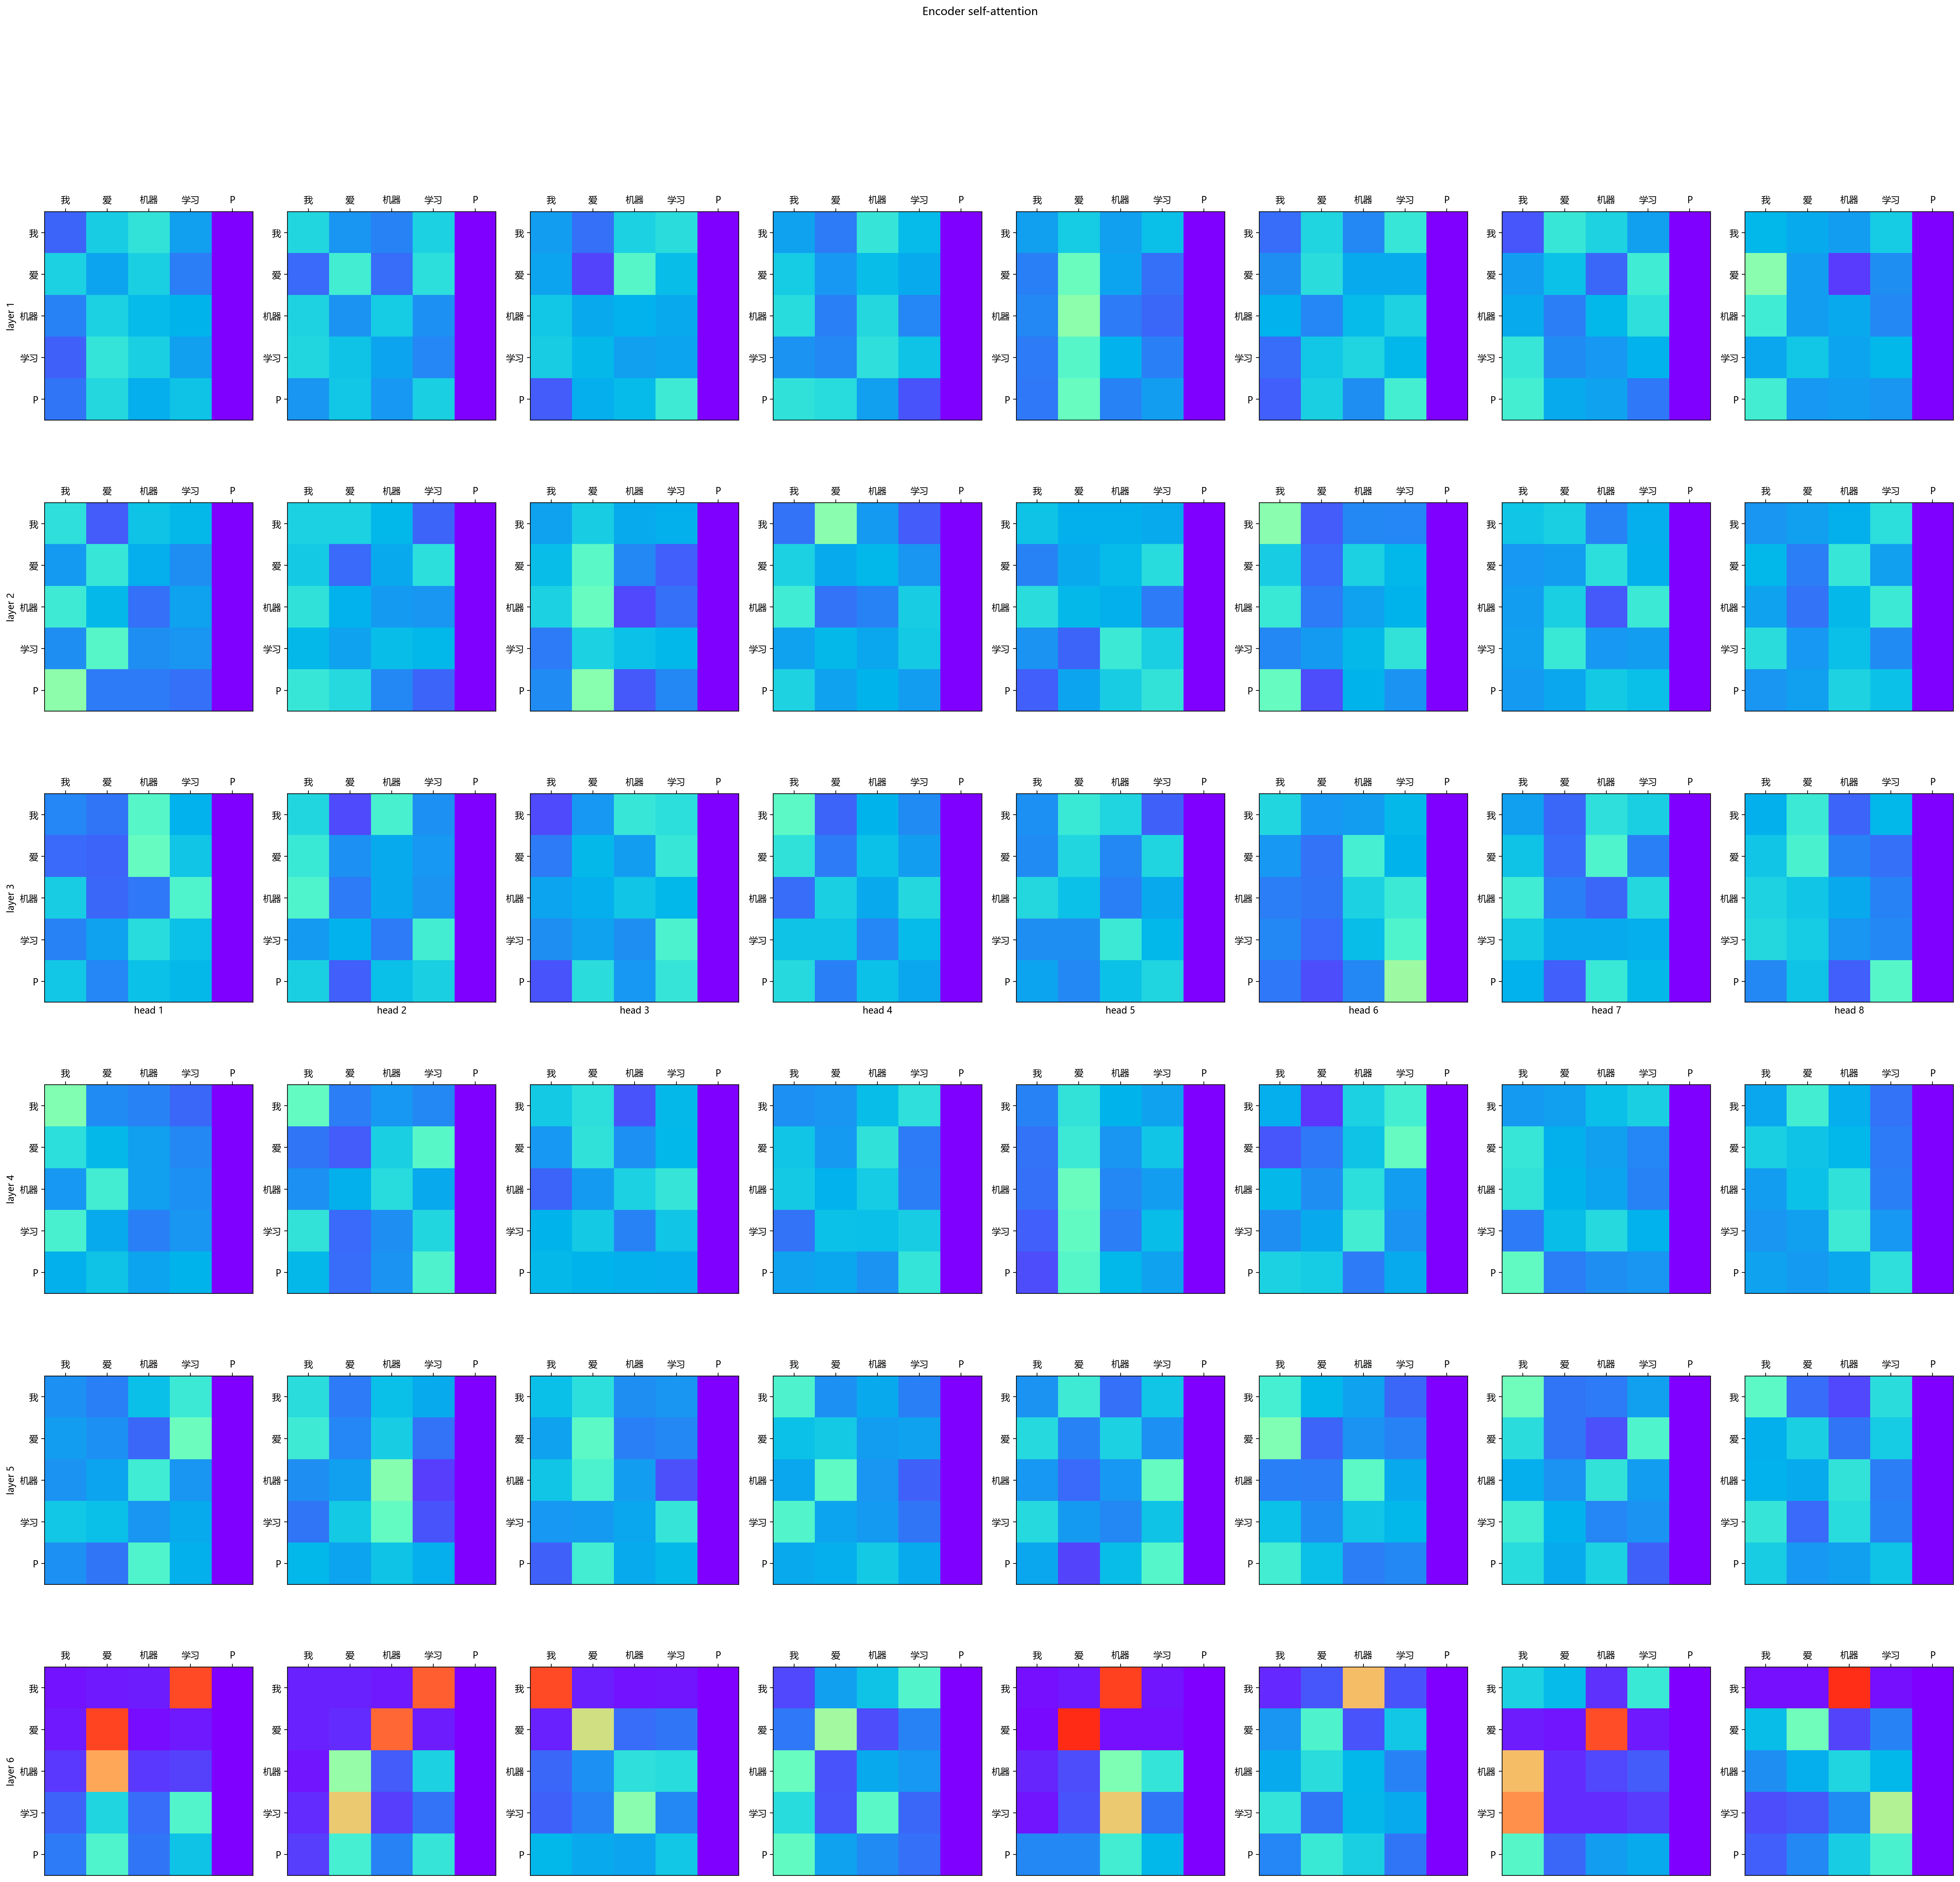

In [131]:
transformer_attention_matrix()

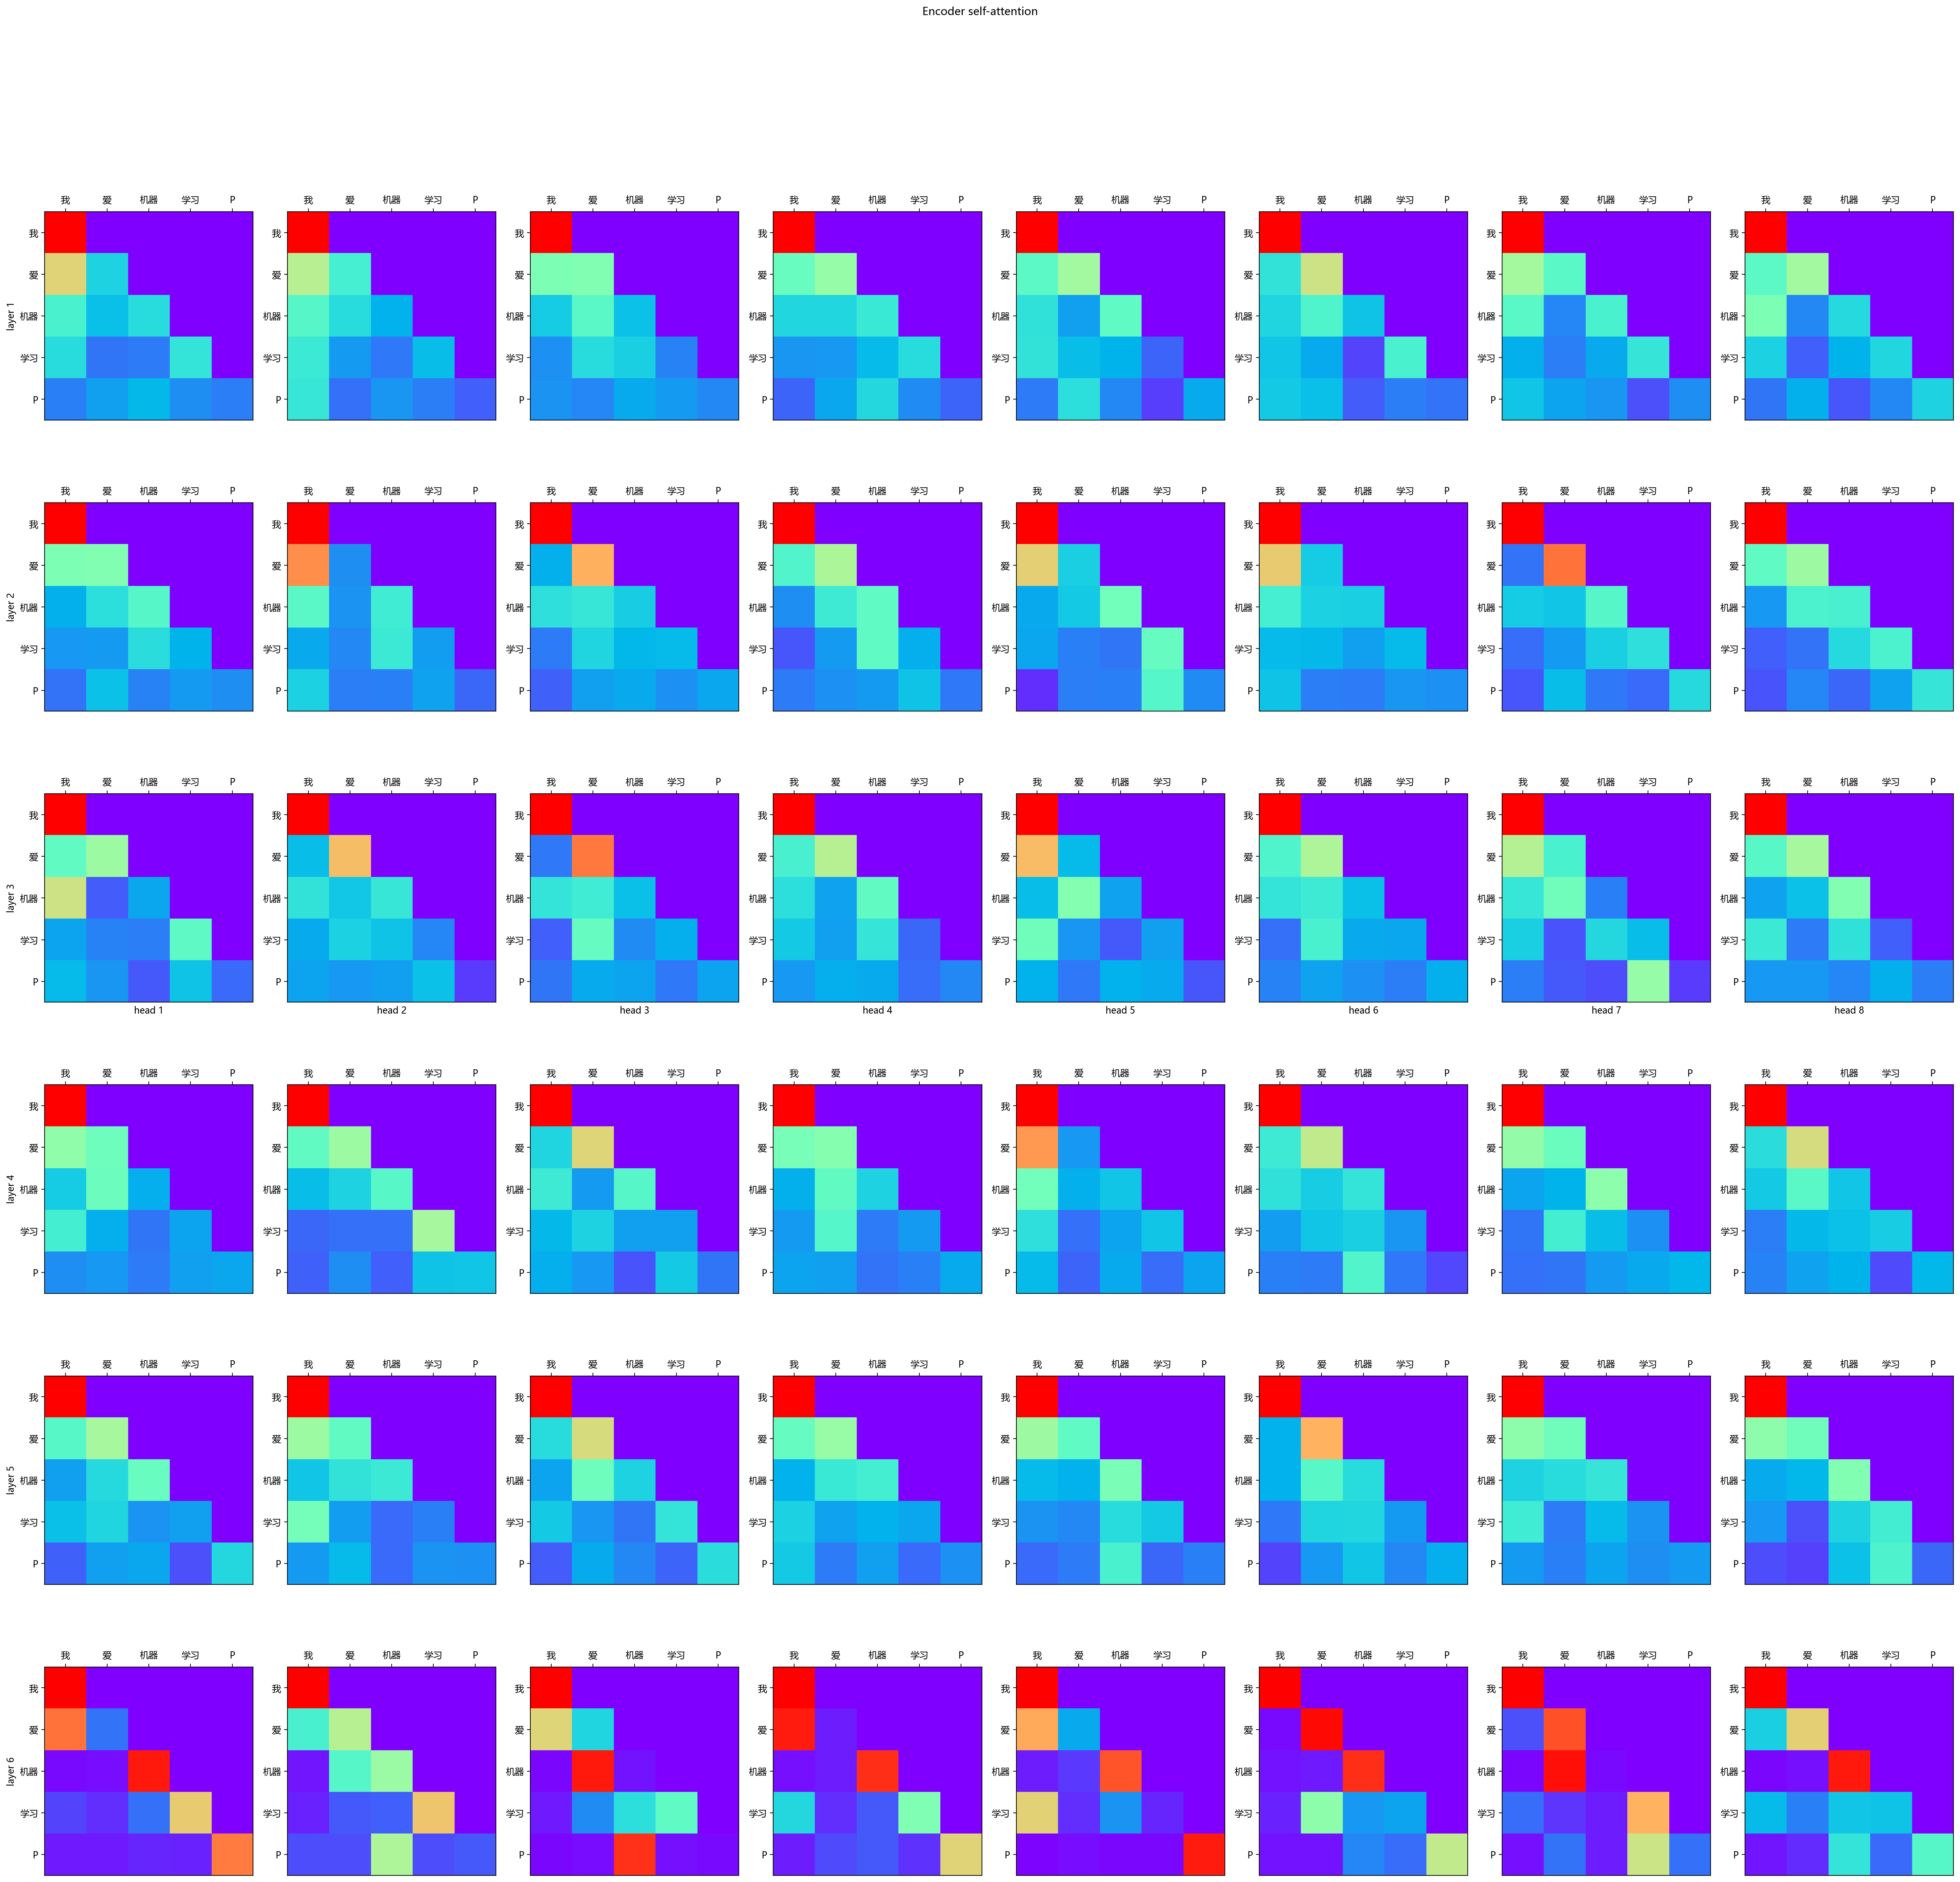

In [134]:
transformer_attention_matrix()

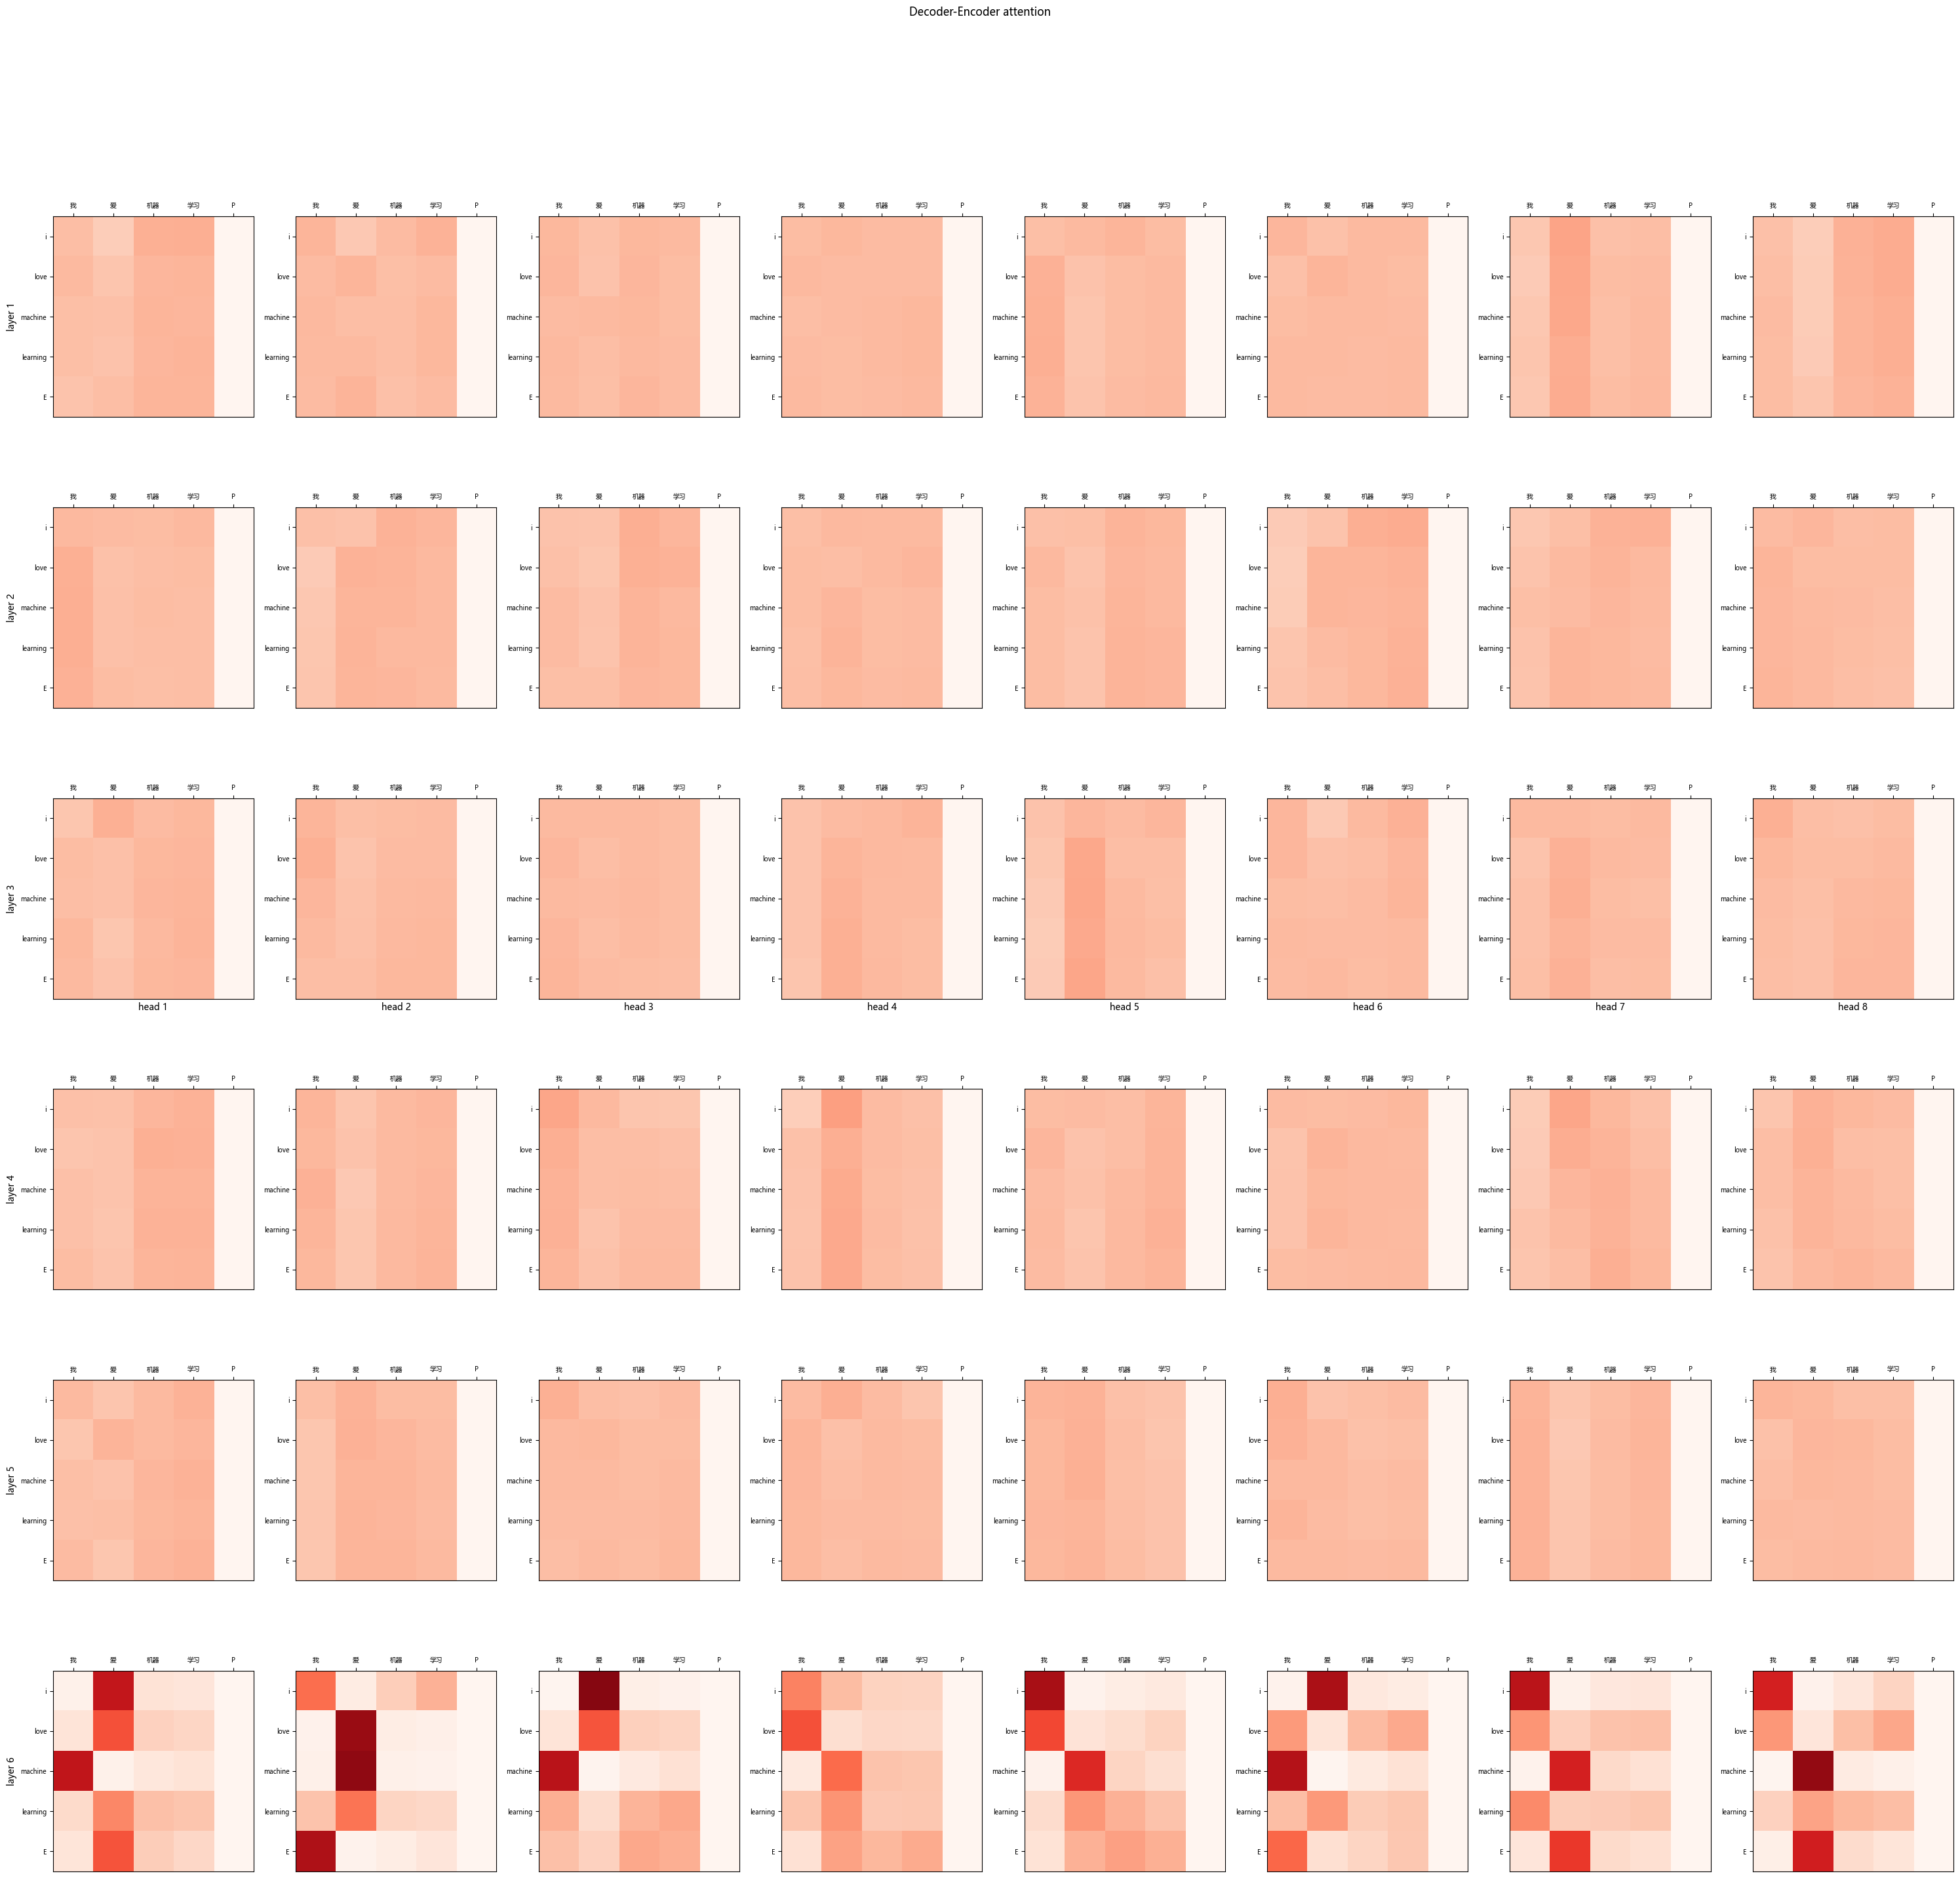

In [146]:
transformer_attention_matrix()

In [190]:
mask = torch.zeros(5,6,dtype=torch.float)

In [259]:
a = torch.randn(5,6)

x = [5,4,3,2,1]
mask = torch.zeros(5,6,dtype=torch.float)
for e_id, src_len in enumerate(x):
    mask[e_id, src_len:] = 1
mask = mask.to(device = 'cpu')
print(mask)
a.data.masked_fill_(mask.bool(),-np.inf)
print(a)

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.]])
tensor([[ 0.1931, -0.9161,  1.2195, -0.8646,  1.2443,    -inf],
        [ 0.6900,  0.8193, -0.0685,  0.7232,    -inf,    -inf],
        [ 0.3260,  0.2160, -1.6251,    -inf,    -inf,    -inf],
        [ 1.1199, -0.6386,    -inf,    -inf,    -inf,    -inf],
        [ 1.4108,    -inf,    -inf,    -inf,    -inf,    -inf]])


In [279]:
attn_shape = [5, 5]
# attn_shape: [batch_size, tgt_len, tgt_len]
subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # ÁîüÊàê‰∏Ä‰∏™‰∏ä‰∏âËßíÁü©Èòµ
subsequence_mask = torch.from_numpy(subsequence_mask)

In [280]:
subsequence_mask

tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]], dtype=torch.float64)

In [283]:
a = torch.randn(128, 8, 5, 5)

In [285]:
a.masked_fill_(subsequence_mask.bool(),-np.inf)

tensor([[[[-8.0376e-01,        -inf,        -inf,        -inf,        -inf],
          [ 1.0697e+00, -2.6869e+00,        -inf,        -inf,        -inf],
          [-1.9440e-01, -7.7337e-02, -1.4543e+00,        -inf,        -inf],
          [-9.2704e-01, -2.0563e+00,  4.2110e-01,  3.5811e-01,        -inf],
          [ 6.9844e-02, -1.7362e+00, -7.0127e-01,  1.4039e-01,  1.7217e+00]],

         [[-5.4034e-01,        -inf,        -inf,        -inf,        -inf],
          [-1.2226e+00,  1.8711e+00,        -inf,        -inf,        -inf],
          [ 1.1235e+00, -1.0016e+00,  1.8371e-01,        -inf,        -inf],
          [ 5.4172e-01, -7.8419e-01, -3.6607e-01, -1.5059e+00,        -inf],
          [-1.5045e+00,  7.9493e-01, -1.6567e-01, -2.5240e-01, -9.7049e-02]],

         [[-1.0502e+00,        -inf,        -inf,        -inf,        -inf],
          [-1.8175e-01,  5.7572e-01,        -inf,        -inf,        -inf],
          [ 1.7086e-01, -8.4632e-01,  4.8386e-01,        -inf,        -i

In [271]:
subsequence_mask = torch.eq(subsequence_mask, 0).float().unsqueeze(0)

In [274]:
subsequence_mask

tensor([[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 0., 1., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [275]:
mask = subsequence_mask.masked_fill_(subsequence_mask.bool(),-np.inf)

In [276]:
mask

tensor([[[0., -inf, -inf, -inf, -inf],
         [0., 0., -inf, -inf, -inf],
         [0., 0., 0., -inf, -inf],
         [0., 0., 0., 0., -inf],
         [0., 0., 0., 0., 0.]]])

In [277]:
subsequence_mask = np.triu(np.ones(attn_shape), k=1)  # ÁîüÊàê‰∏Ä‰∏™‰∏ä‰∏âËßíÁü©Èòµ
subsequence_mask = torch.from_numpy(subsequence_mask).byte()

In [278]:
subsequence_mask

tensor([[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]], dtype=torch.uint8)

In [187]:
mask = torch.eq(mask, 1)

In [188]:
mask

tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]])

In [191]:
mask.masked_fill_(mask.,-np.inf)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [192]:
mask

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [23]:
embeding = nn.Embedding(6, 512)

In [36]:
position = torch.arange(0, 500, dtype=torch.float).unsqueeze(1)

In [37]:
position.shape

torch.Size([500, 1])

In [39]:
max_len = 5000
pe = torch.zeros(max_len, d_model)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
print(div_term.shape)
pe[:, 0::2] = torch.sin(position * div_term)## ËøôÈáåÈúÄË¶ÅÊ≥®ÊÑèÁöÑÊòØpe[:, 0::2]Ëøô‰∏™Áî®Ê≥ïÔºåÂ∞±ÊòØ‰ªé0ÂºÄÂßãÂà∞ÊúÄÂêéÈù¢ÔºåË°•Èïø‰∏∫2ÔºåÂÖ∂ÂÆû‰ª£Ë°®ÁöÑÂ∞±ÊòØÂÅ∂Êï∞‰ΩçÁΩÆ
pe[:, 1::2] = torch.cos(position * div_term)##ËøôÈáåÈúÄË¶ÅÊ≥®ÊÑèÁöÑÊòØpe[:, 1::2]Ëøô‰∏™Áî®Ê≥ïÔºåÂ∞±ÊòØ‰ªé1ÂºÄÂßãÂà∞ÊúÄÂêéÈù¢ÔºåË°•Èïø‰∏∫2ÔºåÂÖ∂ÂÆû‰ª£Ë°®ÁöÑÂ∞±ÊòØÂ•áÊï∞‰ΩçÁΩÆ
## ‰∏äÈù¢‰ª£Á†ÅËé∑Âèñ‰πãÂêéÂæóÂà∞ÁöÑpe:[max_len*d_model]
print(pe.shape)
## ‰∏ãÈù¢Ëøô‰∏™‰ª£Á†Å‰πãÂêéÔºåÊàë‰ª¨ÂæóÂà∞ÁöÑpeÂΩ¢Áä∂ÊòØÔºö[max_len*1*d_model]
pe = pe.unsqueeze(0).transpose(0, 1)
print(pe.shape)

torch.Size([256])
torch.Size([5000, 512])
torch.Size([5000, 1, 512])


In [42]:
pos = np.arange(max_len)[:, None]

In [43]:
pos.shape

(5000, 1)

In [63]:
pos = np.arange(max_len)[:, None]  # [max_len, 1]Êâ©Â±ï‰∏Ä‰∏™Áª¥Â∫¶‰∏∫‰∫ÜÂêéÈù¢Áü©ÈòµËøêÁÆó
pe = pos / np.power(10000, 2. * np.arange(d_model)[None, :] / d_model)  
pe[:, 0::2] = np.sin(pe[:, 0::2])
pe[:, 1::2] = np.cos(pe[:, 1::2])  
# [max_len, dim]
pe = torch.tensor(pe, dtype=torch.float)
pe = pe.unsqueeze(0).transpose(0, 1)
pe = pe[:128, :]

In [64]:
pe.shape

torch.Size([128, 1, 512])

In [112]:
embedding = nn.Embedding(5, 512)

In [114]:
x = torch.LongTensor(torch.rand(1, 5).long())    # embedding‰∏çËÉΩÊé•Êî∂Ë¥üÊï∞ËæìÂÖ• rand(0, 1)ÂèñÊï∞

In [115]:
output = embedding(x)

In [116]:
output.shape

torch.Size([1, 5, 512])

In [105]:
input.unsqueeze(0)

tensor([[[1, 2, 4, 5],
         [4, 3, 2, 9]]])

In [106]:
input

tensor([[1, 2, 4, 5],
        [4, 3, 2, 9]])

In [107]:
sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

In [108]:
input_batch = [[src_vocab[n] for n in sentences[0].split()]]
output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]

In [111]:
input_batch

[[1, 2, 3, 4, 0]]

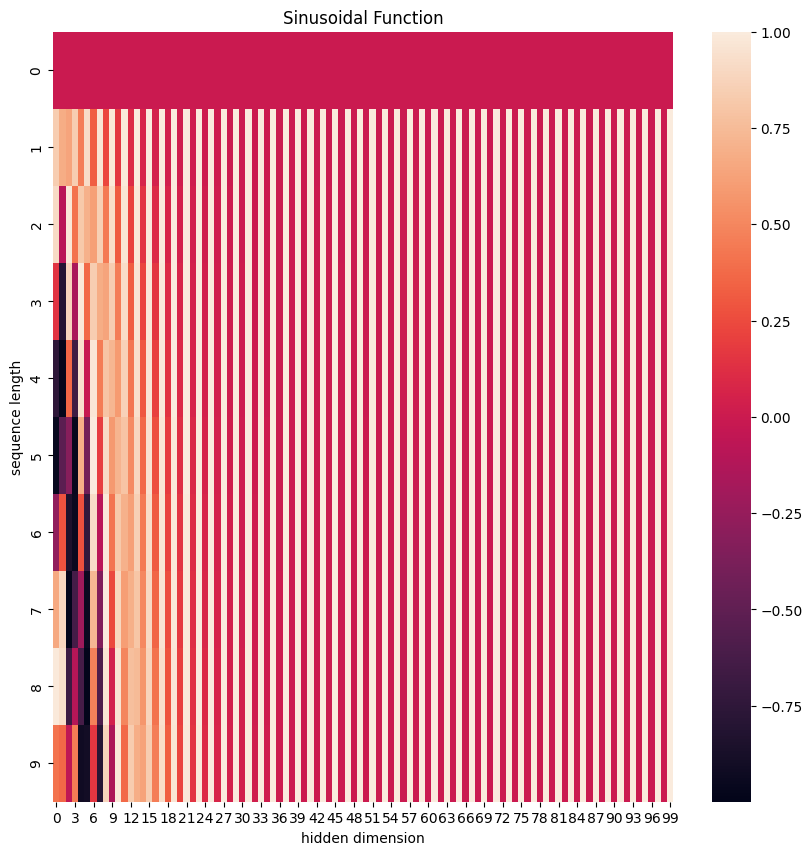

In [293]:
# ‰∏ãÈù¢Áîª‰∏Ä‰∏ã‰ΩçÁΩÆÂµåÂÖ•ÔºåÁ∫µÂêëËßÇÂØüÔºåÂèØËßÅÈöèÁùÄe m b e d d i n g   d i m e n s i o n embedding \ dimensionembedding dimensionÂ∫èÂè∑Â¢ûÂ§ßÔºå
# ‰ΩçÁΩÆÂµåÂÖ•ÂáΩÊï∞ÁöÑÂë®ÊúüÂèòÂåñË∂äÊù•Ë∂äÂπ≥Áºì
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def get_positional_encoding(max_seq_len, embed_dim):
    # ÂàùÂßãÂåñ‰∏Ä‰∏™positional encoding
    # embed_dim: Â≠óÂµåÂÖ•ÁöÑÁª¥Â∫¶
    # max_seq_len: ÊúÄÂ§ßÁöÑÂ∫èÂàóÈïøÂ∫¶
    positional_encoding = np.array([
        [pos / np.power(10000, 2 * i / embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(max_seq_len)])
    
    positional_encoding[1:, 0::2] = np.sin(positional_encoding[1:, 0::2])  # dim 2i ÂÅ∂Êï∞
    positional_encoding[1:, 1::2] = np.cos(positional_encoding[1:, 1::2])  # dim 2i+1 Â•áÊï∞
    return positional_encoding

positional_encoding = get_positional_encoding(max_seq_len=10, embed_dim=100)
plt.figure(figsize=(10,10))
sns.heatmap(positional_encoding)
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")
plt.show()